<h1> Seperation of C3 and C4 from lower alkane hydrocarbons </h1>

<h3> Formulas Used </h3>

$$
ln(x) = A+ {B \over T}+ C lnT+DT
$$

$$
H={1 \over x}
$$
* T in K
* H in atm 
* x= mole fraction of solute in water at soltue partial pressure of 1 atm


In [204]:
import scipy
import scipy.integrate as scint
import scipy.optimize as scopt
import matplotlib.pyplot as plt
import pandas as pd
pi=scipy.pi
e=scipy.e

<h3> Data </h3>

In [205]:
T=25+273.16 #in K
P=101325 #in Pa
#1=methane,#2=Water,#3=propane,#4=butane
#Vapour pressure formula
#ln(P)=c1+c2/T+c3lnT+c4*T^c5
c1=[73.649,83.107,76.945]
c2=[-7258.2,-6486.2,-6729.8]
c3=[-7.3037,-9.2194,-8.179]
c4=[4.1653e-6,6.9844e-6,5.3017e-6]
c5=[2,2,2]
R=8.314472
A=-181.587
B=8632.13
C=24.7981
D=0
H=e**(-1*(A+B/T+C*scipy.log(T)+D*T))*101325
G=30 #mol/s
L=40 #mol/s
Ng1in=100 #mol/s
Ng2in=0
Ng3in=12
Ng4in=15
Nl1in=0
Nl2in=40
Nl3in=0
Nl4in=0
Di=0.5 #column diamter in m
Qg=(Ng1in*18+Ng2in*18+Ng3in*44+Ng4in*58)/(1.184*1e3)
ug=Qg/(0.25*pi*Di**2)
ka=0.0269*ug**0.82
Z=10

In [206]:
def hc(b):
    return e**(c1[b]+c2[b]/T+c3[b]*scipy.log(T)+c4[b]*T**c5[b])

In [207]:
def model(SV,z,obj):
    e=obj.e
    Di=obj.Di
    L=obj.L
    G=obj.G
    P=obj.P
    T=obj.T
    H=obj.H
    Z=obj.Z
    A=obj.A
    B=obj.B
    C=obj.C
    D=obj.D
    [Ng1,Ng2,Ng3,Ng4,Nl1,Nl2,Nl3,Nl4]=SV
    dNg1bydz=-ka/(R*T)*(P*Ng1/(Ng1+Ng2+Ng3+Ng4)-H*Nl1/(Nl1+Nl2+Nl3+Nl4))
    dNg2bydz=-ka/(R*T)*(P*Ng2/(Ng1+Ng2+Ng3+Ng4)-hc(0))
    dNg3bydz=-ka/(R*T)*(P*Ng3/(Ng1+Ng2+Ng3+Ng4)-hc(1))
    dNg4bydz=-ka/(R*T)*(P*Ng4/(Ng1+Ng2+Ng3+Ng4)-hc(2))
    dNl1bydz=ka/(R*T)*(P*Ng1/(Ng1+Ng2+Ng3+Ng4)-H*Nl1/(Nl1+Nl2+Nl3+Nl4))
    dNl2bydz=-ka/(R*T)*(P*Ng2/(Ng1+Ng2+Ng3+Ng4)-hc(0))
    dNl3bydz=-ka/(R*T)*(P*Ng3/(Ng1+Ng2+Ng3+Ng4)-hc(1))
    dNl4bydz=-ka/(R*T)*(P*Ng4/(Ng1+Ng2+Ng3+Ng4)-hc(2))
    return [dNg1bydz,dNg2bydz,dNg3bydz,dNg4bydz,dNl1bydz,dNl2bydz,dNl3bydz,dNl4bydz]


In [208]:
def get_boundary_residuals(SV0,obj):
    z=scipy.array([0,obj.Z])
    trial_solution = scint.odeint(model, SV0, z, args = (obj,))
    SVi = trial_solution[0]
    SVb = trial_solution[-1]
    error = []
    k = 0
    for ic in obj.initial_conditions:
        error.append(ic - SVi[k])
        k += 1
    for bc in obj.boundary_conditions:
        error.append(bc - SVb[k])
        k += 1
    return error

<h3> Applying Boundary Value problem </h3>

In [209]:
class absorption:
    def __init__(self):
        self.e=2.718281828
        self.L=5
        self.G=5
        self.Di=0.5
        self.Z=10
        self.T=25+273.16
        self.P=101325
        self.A=-181.587
        self.B=8632.13 
        self.C=24.7981
        self.D=0
        self.H=e**(-1*(A+B/T+C*scipy.log(T)+D*T))*101325
        self.Ng1in=30
        self.Ng2in=0
        self.Ng3in=12
        self.Ng4in=15
        self.Nl1in=0
        self.Nl2in=40
        self.Nl3in=0
        self.Nl4in=0
    def solve(self):
        self.x=scipy.linspace(0,Z,10)
        self.initial_conditions=[self.Ng1in,self.Ng2in,self.Ng3in,self.Ng4in]
        self.boundary_conditions=[self.Nl1in,self.Nl2in,self.Nl3in,self.Nl4in]
        SV0=self.initial_conditions+self.boundary_conditions
        shooting_method_solution = scopt.least_squares(get_boundary_residuals, SV0,args = (self,))
        SV0=shooting_method_solution.x
        self.solution = scint.odeint(model, SV0,self.x,args = (self,))
        self.solution=pd.DataFrame({"h(m)":self.x,
                "Ng1":self.solution[:,0],
                "Ng2":self.solution[:,1],
                "Ng3":self.solution[:,2],
                "Ng4":self.solution[:,3],
                "Nl1":self.solution[:,4],
                "Nl2":self.solution[:,5],
                "Nl3":self.solution[:,6],
                "Nl4":self.solution[:,7],})
    def plot(self):
        fig = plt.figure()
        ay = fig.add_subplot(121)
        ay.plot(self.solution["h(m)"],self.solution["Ng1"],'r',label="Methane")
        ay.plot(self.solution["h(m)"],self.solution["Ng2"],'g',label="Water")
        ay.plot(self.solution["h(m)"],self.solution["Ng3"],'b',label="Propane")
        ay.plot(self.solution["h(m)"],self.solution["Ng4"],'y',label="Butane")
        ay.legend()
        ay.title.set_text("Flow rates in the gas phase")
        ay.xaxis.label.set_text("Height")
        ay.yaxis.label.set_text("moles per second")
        ax = fig.add_subplot(122)
        ax.plot(self.solution["h(m)"],self.solution["Nl1"],'r',label="Methane")
        ax.plot(self.solution["h(m)"],self.solution["Nl2"],'g',label="Water")
        ax.plot(self.solution["h(m)"],self.solution["Nl3"],'b',label="Propane")
        ax.plot(self.solution["h(m)"],self.solution["Nl4"],'y',label="Butane")
        ax.legend()
        ax.title.set_text("Flow rates in the liquid phase")
        ax.xaxis.label.set_text("Height")

In [210]:
ccgas=absorption()
ccgas.Z=10

In [211]:
ccgas.solve()

<h3> Flowsheet </h3>

In [212]:
ccgas.solution

,h(m),Ng1,Ng2,Ng3,Ng4,Nl1,Nl2,Nl3,Nl4
0,0.000000,30.000000,8.069046e-10,12.000000,15.000000,-0.132883,38.791029,5.579589e+00,1.154830e+01
1,1.111111,29.866770,2.988101e-01,11.123259,12.773607,0.000347,39.089839,4.702849e+00,9.321910e+00
2,2.222222,29.866770,5.424077e-01,10.304774,10.828914,0.000347,39.333437,3.884363e+00,7.377217e+00
3,3.333333,29.866770,7.366282e-01,9.549621,9.150191,0.000346,39.527657,3.129210e+00,5.698494e+00
4,4.444444,29.866771,8.876953e-01,8.861286,7.718251,0.000346,39.678724,2.440876e+00,4.266554e+00
5,5.555556,29.866771,1.001966e+00,8.241471,6.511169,0.000346,39.792995,1.821061e+00,3.059472e+00
6,6.666667,29.866771,1.085668e+00,7.690042,5.505220,0.000346,39.876697,1.269632e+00,2.053523e+00
7,7.777778,29.866771,1.144655e+00,7.205140,4.675931,0.000345,39.935684,7.847296e-01,1.224234e+00
8,8.888889,29.866772,1.184220e+00,6.783425,3.999102,0.000345,39.975249,3.630142e-01,5.474054e-01
9,10.000000,29.866772,1.208971e+00,6.420411,3.451697,0.000345,40.000000,-6.502894e-09,-9.126016e-09


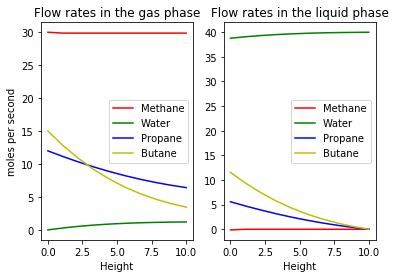

In [213]:
ccgas.plot()